# Sentiment Analysis and Cosine Similarity Recommender System


**MOTIVATION**

**Part 1** Developed a a series of data preprocessing tasks, utilizing actual datasets from [Amazon Data 2018](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/). Performed Sentiment Analysis

**Part 2** Conduct a recommendation by using cosine similarity.

### Amazon Review Dataset Information

The [Amazon Review Data (5-core)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#subsets) contains review data for individual products, reduced to extract the 5-core such that each user has at least 5 reviews and each item has at least 5 reviews.

- **overall**: Rating of the product.
- **verified:** Indicates whether the user is verified.
- **reviewTime:** Datetime of the review in raw format. (e.g., 09 1, 2016)
- **reviewerID:** ID of the reviewer (e.g., A2SUAM1J3GNN3B).
- **asin:** ID of the product (e.g., 0000013714).
- **style:** A dictionary of product metadata. (e.g., {'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice Blue'})
- **reviewerName:** Name of the reviewer.
- **reviewText:** Text of the review.
- **summary:** Summary of the review.
- **unixReviewTime:** Datetime of the review in Unix time. (Same timestamp as reviewTime but in a different format)
- **vote:** Helpful votes of the review.
- **image:** Image links posted after receiving the product.

### Amazon Meta Dataset Information

The [Amazon Meta Data (complete)](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon_v2/#complete-data) includes meta information for individual products, such as description, price, sales rank, brand info, and co-purchasing links.

- **category:** List of categories the product belongs to.
- **tech1:** The first tech detail table of the product.
- **description:** Description of the product.
- **fit:** The fit of the product. (Amazon uses customer feedback for size guidance. Users can choose the size feedback among the list. This feature contains a summary of different numbers of feedback across 5 size categories. Please note that fit information is available for Fashion product but not Beauty product.)
- **title:** Name of the product.
- **also_buy:** Related products also bought.
- **tech2:** The second tech detail table of the product.
- **brand:** Brand name.
- **feature:** Bullet-point format features of the product.
- **rank:** Sales rank information.
- **also_view:** Related products also viewed.
- **details:** Product details.
- **main_cat:** Category of product.
- **similar_item:** Similar product table.
- **date:** Date first available (at time of crawl).
- **price:** Price in US dollars (at time of crawl).
- **asin:** ID of the product (e.g., 0000031852).
- **imageURL:** URL of the product image.
- **imageURLHighRes:** URL of the high-resolution product image.

### Import Packages Needed

In [4]:
import os
import json
import gdown
import pandas as pd
import numpy as np
from scipy.stats import zscore
### Plot
import matplotlib.pyplot as plt
import seaborn as sns
### HTML
from bs4 import BeautifulSoup
import re
### Warnings
import warnings
### Text Preprocessing and Natural Language Processing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import nltk
import re
import spacy
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'gdown'

### Download Data Files Needed

In [5]:
# For Amazon Reivew Data
review_file_ids = {
    'All_Beauty_5.json': '1kommjYLqN_d4CUx0Gp_8vEDoxY1lJZ3N',
    'AMAZON_FASHION_5.json': '1tcCq8bT1jwLX8DdcGcAMPGuTGyl7iOqa',
}

# For Amazon Meta Data
meta_file_ids = {
    'meta_All_Beauty.json': '15HgucSX3RNmZ4vq4lhv_bhX6i2sAd2jU',
    'meta_AMAZON_FASHION.json': '1l-ItU19ggeSLkgahodzjnFkvK46MOU2G',
}

# Download files from Google Drive using gdown
for filename, file_id in review_file_ids.items():
    gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)
    print(f'Downloaded: {filename}')

for filename, file_id in meta_file_ids.items():
    gdown.download(f'https://drive.google.com/uc?id={file_id}', filename, quiet=False)
    print(f'Downloaded: {filename}')

Downloading...
From: https://drive.google.com/uc?id=1kommjYLqN_d4CUx0Gp_8vEDoxY1lJZ3N
To: /content/All_Beauty_5.json
100%|██████████| 2.46M/2.46M [00:00<00:00, 16.0MB/s]


Downloaded: All_Beauty_5.json


Downloading...
From: https://drive.google.com/uc?id=1tcCq8bT1jwLX8DdcGcAMPGuTGyl7iOqa
To: /content/AMAZON_FASHION_5.json
100%|██████████| 1.41M/1.41M [00:00<00:00, 10.7MB/s]


Downloaded: AMAZON_FASHION_5.json


Downloading...
From: https://drive.google.com/uc?id=15HgucSX3RNmZ4vq4lhv_bhX6i2sAd2jU
To: /content/meta_All_Beauty.json
100%|██████████| 66.4M/66.4M [00:00<00:00, 120MB/s]


Downloaded: meta_All_Beauty.json


Downloading...
From (original): https://drive.google.com/uc?id=1l-ItU19ggeSLkgahodzjnFkvK46MOU2G
From (redirected): https://drive.google.com/uc?id=1l-ItU19ggeSLkgahodzjnFkvK46MOU2G&confirm=t&uuid=ab7fe68f-6d17-460d-86e7-f90d02d37eb8
To: /content/meta_AMAZON_FASHION.json
100%|██████████| 193M/193M [00:01<00:00, 145MB/s]

Downloaded: meta_AMAZON_FASHION.json


## Data Loading

Load the Amazon Review Data files (**All_Beauty_5.json** and **AMAZON_FASHION_5.json** in `review_file_ids`) into a pandas DataFrame `review_df_raw`:

1. Initialize an empty list `review_data` to store the review data.
2. Iterate through the files in `review_file_ids`.
3. For each file, read and append the JSON data to the review_data using `json.loads()` and `line.strp()`.
4. Create the DataFrame `review_df_raw` from `review_data` list.

Similarly, load the Amazon Meta Data files (**meta_All_Beauty.json** and **meta_AMAZON_FASHION.json** in `meta_file_ids`) into a pandas DataFrame `meta_df_raw` ad check the shapes of both DataFrames.

In [6]:
# Initialize an empty list to store the review data
review_data = []

for filename, file_id in review_file_ids.items():
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            review_data.append(json.loads(line.strip()))

# Create a DataFrame from the review_data
review_df_raw = pd.DataFrame(review_data)

print("Dataframe Shape:", review_df_raw.shape)
review_df_raw.head(6)

Dataframe Shape: (8445, 12)


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN
5,5.0,False,"05 16, 2010",A24HQ2N7332W7W,B00006L9LC,{'Size:': ' 366'},Kindle Customer Joyce Wilson,"If you know the scent of Diva, you'll LOVE thi...",Diva is Heavenly,1273968000,NaN,NaN


In [7]:
meta_data = []

for filename, file_id in meta_file_ids.items():
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            meta_data.append(json.loads(line.strip()))

meta_df_raw = pd.DataFrame(meta_data)

print("Dataframe Shape:", meta_df_raw.shape)
meta_df_raw.head(6)

Dataframe Shape: (219529, 19)


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
5,[],,[Mary Kay Satin Hands Peach Hand Cream Travel ...,,Mary Kay Satin Hands Hand Cream Travel MINI Si...,[],,Mary Kay,[],"699,317 in Beauty & Personal Care (",[],"{'Shipping Weight:': '2.4 ounces', 'ASIN: ': '...",All Beauty,,,,7535842801,[],[]


## Remove Duplicate Rows


- Review Data: overall, reviewTime, reviewerID, asin, reviewText, vote.
- Meta Data: fit, title, price, asin.

1. Create two new DataFrames (`review_df` and `meta_df`) by selecting the specifc columns mentioned above from the original DataFrames `review_df_raw` and `meta_df_raw`.
2. Drop duplicate rows from each dataframe and reset the index.

In [8]:
### review_df 
review_df = review_df_raw[["overall", "reviewTime", "reviewerID", "asin", "reviewText", "vote"]]
print(type(review_df))
print(review_df.head(3))

review_df = review_df.drop_duplicates().reset_index()
print(review_df.shape)


<class 'pandas.core.frame.DataFrame'>
   overall   reviewTime      reviewerID        asin  \
0      5.0   09 1, 2016  A3CIUOJXQ5VDQ2  B0000530HU   
1      5.0  11 14, 2013  A3H7T87S984REU  B0000530HU   
2      1.0  08 18, 2013  A3J034YH7UG4KT  B0000530HU   

                                          reviewText vote  
0                   As advertised. Reasonably priced  NaN  
1  Like the oder and the feel when I put it on my...  NaN  
2  I bought this to smell nice after I shave.  Wh...  NaN  
(7309, 7)


In [9]:
meta_df = meta_df_raw[["fit", "title", "price", "asin"]]
print(type(meta_df))
print(meta_df.head(3))

meta_df = meta_df.drop_duplicates().reset_index()
print(meta_df.shape)


<class 'pandas.core.frame.DataFrame'>
  fit                                              title   price        asin
0          Loud 'N Clear&trade; Personal Sound Amplifier          6546546450
1      No7 Lift &amp; Luminate Triple Action Serum 50...  $44.99  7178680776
2        No7 Stay Perfect Foundation Cool Vanilla by No7  $28.76  7250468162
(218682, 5)


## Remove Outliers


#### title 

The `title` column of `meta_df`, which is of string type, contains values with unusually long lengths, indicating the presence of outliers. Identify the outliers using [Z-score method](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)

1. Create a new column `title_length` in the DataFrame `meta_df` by calculating the length of each title. (Set the value as 0 if the correponding `title` column has NaN values.)
2. Check the statistics of `title_length` using `describe()` method.
3. Calculate the mean and standard deviation of the `title_length` column.
4. Set the threshold for identifying outliers to 3.
5. Identify outliers of the `title_length` column and set the corresponding titles to np.nan.
6. Drop the `title_length` column from the DataFrame.

In [10]:

meta_df['title_length'] = meta_df['title'].apply(lambda x: len(x) if pd.notna(x) else 0)
# print(meta_df.head(3))

TL = meta_df["title_length"]
stats_TL = TL.describe()
print(stats_TL)

count    218682.000000
mean        203.163114
std        3918.966900
min           0.000000
25%          56.000000
50%          71.000000
75%          84.000000
max      424341.000000
Name: title_length, dtype: float64


In [11]:

mean_TL = TL.mean()
# print(mean_TL)

sd_TL = TL.std()
# print(sd_TL)

threshold = 3

z_score = zscore(TL)
# print(z_score)

meta_df.loc[abs(z_score) > threshold, 'title'] = np.nan
# print(meta_df.head(3))

meta_df = meta_df.drop("title_length", axis=1)
# print(meta_df.head(3))

#### Price

Similarly, the `price` column of `meta_df` (of type `str`) also contains values with unusually long lengths, indicating the presence of outliers.

1. Create a new column `price_length` in the DataFrame `meta_df` by calculating the length of each price value. (Set the value as 0 if the correponding `price` column has NaN values.)
2. Check the statistics of `price_length` using `describe()` method and display its unique values.
3. Identify the outlier values by inspecting the content in `price` corresponding to the abnormal value in `price_length` and set the corresponding value of `price` to np.nan.
4. Drop the `price_length` column from the DataFrame.

In [12]:
### Drop outliers: price (meta_df)

meta_df["price_length"] = meta_df["price"].apply(lambda x: len(x) if pd.notna(x) else 0)

print(meta_df['price_length'].describe())

print(meta_df['price_length'].unique())

length_counts = meta_df['price_length'].value_counts()
# print(length_counts)

print(meta_df[meta_df["price_length"] == 10])
print(meta_df[meta_df["price_length"] == 10].index[0])
# abnormal price observed

count    218682.000000
mean          4.534324
std         130.301479
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4648.000000
Name: price_length, dtype: float64
[   0    6 4648   10    5    7    9   16   14   15   17   13   21   19
   18]
         index  fit                                              title  \
25          25       Norelco 5841XL Deluxe Reflex Action Cord/Cordl...   
51959    52806  NaN  Cartier 18k Rose Gold & Diamond Tank Anglaise ...   
138018  138865  NaN  Breitling Ab0420b9-Bb56 Men's Chronomat 44 Aut...   

                price        asin  price_length  
25      \n\n\n<script  B000050B62            10  
51959      $69,995.00  B00ARGHNR0            10  
138018     $10,020.00  B012Z4447S            10  
25


In [13]:

meta_df.loc[(meta_df["price_length"] == 0) | (meta_df["price_length"] == 4648), "price"] = np.nan
meta_df.at[25, "price"] = np.nan

meta_df.drop(columns=["price_length"], inplace=True)

## Handle Missing Values

For Amazon Review Data `review_df`:
1. Check the count of missing values in each column and drop the rows where `reviewText` is NaN and then reset the index.
2. Fill NaN values in the `vote ` column with empty string `''`.

For Amazon Meta Data `meta_df`:
1. Check the count of missing values in each column and drop the rows where `title` or `price` is NaN and then reset the index.
2. Fill NaN values in the `fit ` column with empty string `''`.

In [14]:
### review_df

print(review_df.isnull().sum())

review_df = review_df.dropna(subset=["reviewText"])
review_df.reset_index(drop=True, inplace=True)

review_df["vote"].fillna('', inplace=True)

index            0
overall          0
reviewTime       0
reviewerID       0
asin             0
reviewText      20
vote          6578
dtype: int64


<ipython-input-14-734b0d3dbac9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df["vote"].fillna('', inplace=True)


In [15]:
### meta_df

print(meta_df.isnull().sum())

meta_df = meta_df.dropna(subset=["title", "price"])
meta_df.reset_index(drop=True, inplace=True)

meta_df["fit"].fillna('', inplace=True)

index         0
fit      181367
title       435
price    189719
asin          0
dtype: int64


<ipython-input-15-626cb9ba680e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_df["fit"].fillna('', inplace=True)


## Feature Engineering

#### Merge Two DataFrames

1. Based on the `asin` values (product IDs), check the match between `review_df` and `meta_df`

2. Merge the `review_df` and `meta_df` DataFrames into `data_df` by performing a left join of `meta_df` to `review_df` based on the `asin` column.

3. Remove rows with missing values and reset the index.

In [16]:
# 1) Calculate the number of products with product information (asin in meta_df)
# but no review information (asin not in review_df)
meta_asin_total = set(meta_df["asin"])
review_asin_total = set(review_df["asin"])
meta_asin_diff = set()

for i in meta_asin_total:
    if i not in review_asin_total:
        meta_asin_diff.add(i)

print(meta_asin_diff)
print(len(meta_asin_diff))


{'B00KM5I8U2', 'B00EO9PKFI', 'B00GALUKBM', 'B01448PST6', 'B0149LAECY', 'B017LVXPAC', 'B0169MXKPO', 'B001DYF2AA', 'B015A9UJ1K', 'B000V4T9PW', 'B00GS7AJCS', 'B017XXWPOU', 'B00BFMFUIE', 'B00F2DIRQ4', 'B019IO17YG', 'B00KYALAG4', 'B01G94Y59C', 'B01A40SM50', 'B00JU7C5T8', 'B00V329VB8', 'B00SYH7TZK', 'B00SFZF6YC', 'B00SG6Y1Q4', 'B01E7VNZAE', 'B003TMVSU2', 'B019HX8K8Y', 'B00JGBDM9K', 'B01B67C062', 'B00R6D0Z86', 'B00OLL59QO', 'B01CK9TRLG', 'B00R0I5J9C', 'B001H66RL2', 'B0194YZ912', 'B006TJU5II', 'B00FM6SU0Y', 'B00OUU78R4', 'B013JV5OG6', 'B00KWKJUOK', 'B01GTQXKAU', 'B01B0M7ZZY', 'B01F4NXSL0', 'B0160IR8F0', 'B007R4CMSK', 'B01E5YLYFG', 'B0114CX0ZE', 'B017WYXKWQ', 'B00OHWTT54', 'B00LBJJCOE', 'B01B87AK2G', 'B01F9N42OM', 'B0118C6W32', 'B00K2Z1HMS', 'B00Y63N2KM', 'B001MU3NSS', 'B00D0HNQ1K', 'B00MA5YIXI', 'B007JKCLX8', 'B00HI3IMIY', 'B0083PXVPU', 'B018IVG82Q', 'B00NB4QATW', 'B01B6Z6F38', 'B00RL1L6AY', 'B00HZ31VBC', 'B00SPVIASK', 'B00IEKUGT8', 'B00IJE4VRC', 'B01B6KCEL0', 'B01F346J0M', 'B00N2AJN5I', 'B00I

In [17]:
# 2) Calculate the number of products with review information (asin in review_df)
# but no product information (asin not in meta_df)
review_asin_diff = set()

for i in review_asin_total:
    if i not in meta_asin_total:
        review_asin_diff.add(i)

print(review_asin_diff)
print(len(review_asin_diff))

{'B00VARTPKS', 'B01DKQAXC0', 'B000GLRREU', 'B00JF2GVWK', 'B000YFSR4W', 'B004KEJ65C', 'B001OHV1H4', 'B0014HA6VG', 'B008YQM4A6', 'B00IJHY54S', 'B00VG1AV5Q', 'B00EYZY6LQ', 'B019V2KYZS', 'B00CQ0LN80', 'B000NKJIXM', 'B00MTR49IG', 'B0014F7B98', 'B00L1I1VMG', 'B0013NB7DW', 'B0009RF9DW', 'B01595OS62', 'B007V6JNE0', 'B004CALFE4', 'B00B9V9ASM', 'B000W0C07Y', 'B000FOI48G', 'B0000530HU', 'B00N2WQ2IW', 'B00ZUA6AJK', 'B0011FYB5I', 'B00QXW95Q4', 'B0012Y0ZG2', 'B000VV1YOY', 'B00HLXEXDO', 'B00CZH3K1C', 'B000URXP6E', 'B000FTYALG', 'B000FI4S1E', 'B01BNEYGQU', 'B00DY59MB6', 'B01DLR9IDI', 'B019LAI4HU', 'B00AKP21KM', 'B00RZYW4RG', 'B019809F9Y', 'B00UWB35UY'}
46


In [18]:
# 3) For products with review information (asin in review_df) but no product
# information (asin not in meta_df), what is the number of reviews for each product?
# Create a DataFrame with columns 'asin' and 'reviewCount' to show the result.
# Sort the DataFrame by 'reviewCount' in descending order and display the top 5 rows

d = {"asin": [], "reviewCount":[]}
for asin in review_asin_diff:
    review_count = review_df[review_df["asin"] == asin]["overall"].count()
    d["asin"].append(asin)
    d["reviewCount"].append(review_count)

review_asin_df = pd.DataFrame(d)
# print(review_asin_df)

review_asin_df = review_asin_df.sort_values(by="reviewCount", ascending=False)
print(review_asin_df.head(5))

          asin  reviewCount
31  B0012Y0ZG2          878
35  B000URXP6E          856
6   B001OHV1H4          488
19  B0009RF9DW          391
37  B000FI4S1E          391


In [19]:
data_df = pd.merge(review_df, meta_df, on="asin", how="left")

data_df = data_df.dropna().reset_index(drop=True)
print(data_df)

      index_x  overall   reviewTime      reviewerID        asin  \
0           4      5.0   05 6, 2011  A3SFRT223XXWF7  B00006L9LC   
1           5      5.0  05 16, 2010  A24HQ2N7332W7W  B00006L9LC   
2           6      5.0   05 7, 2018  A2G90R2ZU6KU5D  B00006L9LC   
3           7      2.0   05 7, 2018  A24W4W9E62FZP2  B00006L9LC   
4           8      1.0   05 6, 2018   A7ID5H7FWLJHC  B00006L9LC   
...       ...      ...          ...             ...         ...   
3549     8440      5.0   07 2, 2018  A2077NII5H62R2  B005AGO4LU   
3550     8441      5.0  06 28, 2018  A2IBS6PIPAGAB5  B005AGO4LU   
3551     8442      5.0  06 25, 2018  A1GTC5EVSJNCQ8  B005AGO4LU   
3552     8443      5.0  06 20, 2018  A311XHHLM12MUT  B005AGO4LU   
3553     8444      5.0  06 16, 2018  A135SGOQMVWABQ  B005AGO4LU   

                                             reviewText vote  index_y  \
0     If you ever want to feel pampered by a shampoo...    3    111.0   
1     If you know the scent of Diva, you'll LOVE 


Convert `reviewTime` Column to Datetime using `pd.to_datetime()`.


In [20]:
data_df["reviewTime"] = pd.to_datetime(data_df["reviewTime"])

#### fit 

Amazon utilizes customer feedback for size guidance, allowing users to select the size feedback from a list. The `fit` column contains a summary of different numbers of feedback across five size categories for each product. As this feature presents size feedback in string format with HTML tags, we need to use feature engineering to extract useful information.

1. Select one HTML string value from the `fit` column (`example_html`) where the value is not empty.
2. Apply the `extract_size_feedback` function on the HTML string (`example_html`) to check the function output.
3. Create a list of the unique size feedback categories from the `fit` column by **iterating** over each HTML string in the `fit` column of the `data_df` DataFrame and extracting the size feedback categories.
4. For each size feedback category, use the `apply` function to create a new column (named by the size feedback category), the cell value should be the corresponding number of feedback of this size category for this product extracted by `extract_size_feedback` (If the `fit` column is empty, set the count to 0.)
5. Drop the `fit` column.

In [21]:
def extract_size_feedback(html_string):
    """
    Extracts size feedback information from HTML string.

    Parameters:
    - html_string (str): The HTML string containing size feedback information.

    Returns:
    - dict: A dictionary with size labels as keys and corresponding feedback counts as values.
    """
    # Parse HTML with BeautifulSoup
    soup = BeautifulSoup(html_string, 'html.parser')

    # Initialize a dictionary to store size feedback
    size_feedback = {}

    # Find all rows in the histogram
    rows = soup.find_all('tr', class_='a-histogram-row')

    # Extract information for each size category
    for row in rows:
        # Extract size label
        size_label = row.find('span').get_text(strip=True)

        # Extract count
        count = int(row.find('span').findNext('span').get_text(strip=True).replace(',', ''))

        size_feedback[size_label] = count

    return size_feedback

In [22]:
### fit
example_html = data_df["fit"][3553]
# print(example_html)

example_output = extract_size_feedback(example_html)
print(example_output)

{'Too small': 10, 'Somewhat small': 27, 'Fits as expected': 502, 'Somewhat large': 65, 'Too large': 30}


In [23]:
unique_feedback = set()
for html in data_df["fit"]:
    if not pd.isna(html):
        size_feedback = extract_size_feedback(html)
        unique_feedback.update(size_feedback.keys())
print(unique_feedback)


{'Fits as expected', 'Somewhat small', 'Too small', 'Too large', 'Somewhat large'}


In [24]:
### Create a new column in data_df for each size feedback category
for size in unique_feedback:
    data_df[size] = data_df["fit"].apply(lambda x: extract_size_feedback(x).get(size, 0))
print(data_df.head(3))

### Drop the original 'fit' column
data_df = data_df.drop(columns=["fit"])

   index_x  overall reviewTime      reviewerID        asin  \
0        4      5.0 2011-05-06  A3SFRT223XXWF7  B00006L9LC   
1        5      5.0 2010-05-16  A24HQ2N7332W7W  B00006L9LC   
2        6      5.0 2018-05-07  A2G90R2ZU6KU5D  B00006L9LC   

                                          reviewText vote  index_y fit  \
0  If you ever want to feel pampered by a shampoo...    3    111.0       
1  If you know the scent of Diva, you'll LOVE thi...         111.0       
2  Got this shampoo as a solution for my wife's d...         111.0       

                                           title   price  Fits as expected  \
0  Citre Shine Moisture Burst Shampoo - 16 fl oz  $23.00                 0   
1  Citre Shine Moisture Burst Shampoo - 16 fl oz  $23.00                 0   
2  Citre Shine Moisture Burst Shampoo - 16 fl oz  $23.00                 0   

   Somewhat small  Too small  Too large  Somewhat large  
0               0          0          0               0  
1               0        

The `price` column contains the price information of each product in string form. For each product, its `price` can be either a single price or a price range. Extract the price information by the following steps:

1. Use the `apply` function on the `price` column of the DataFrame (`data_df`) to create a list (`len_idx`) containing the length of each value in the `price` column (converted to strings). The length represents the number of characters in each price value.
2. Define a function `extract_price_range` that takes a price string as input and returns a dictionary with 'min' and 'max' keys representing the minimum and maximum price values. (If the `price` is a single value, set minimum and maximum values to be the same.)
3. Use the `apply` function to create new columns (`min_price` and `max_price`) in the DataFrame by extracting minimum and maximum prices from the `price` column using the defined function.
4. Drop the `price` column.

In [25]:
### price
# print(data_df["price"])
len_idx = data_df["price"].apply(lambda x: len(str(x)))
print(len_idx)

0        6
1        6
2        6
3        6
4        6
        ..
3549    16
3550    16
3551    16
3552    16
3553    16
Name: price, Length: 3554, dtype: int64


In [26]:
### Define function to extract price range
def extract_price_range(price):
    min_price = None
    max_price = None
    lst = price.split(" - ")
    if len(lst) > 1:
        min_price = float(lst[0][1:])
        max_price = float(lst[1][1:])
    else:
        min_price = max_price = float(lst[0][1:])
    return {'min':min_price, 'max':max_price}

In [27]:
### Create two new colulmns 'min_price' and 'max_price'
# print(extract_price_range(data_df["price"][3552]))
data_df[["min_price", "max_price"]] = data_df["price"].apply(extract_price_range).apply(pd.Series)


### Drop the original 'price' column
data_df = data_df.drop(columns=["price"])
# print(data_df.tail(3))

#### Task 5.5: vote (0.1 marks)

Convert the `vote` from string to numeric values. (If the `vote` column is empty, set the count to 0.)

In [28]:
### vote
data_df['vote'] = pd.to_numeric(data_df['vote'], errors='coerce').fillna(0).astype(int)

Text processing is vital in NLP tasks to clean and structure raw text data. For this task, define a function `process_text` that takes a textual value as input and applies the following processing steps in sequence:

1. Convert the input text to lowercase using the `lower()` function.

2. Tokenize the lowercase text using the `word_tokenize` function from the NLTK library.

3. Create a list (`alphabetic_tokens`) containing only alphabetic tokens using a list comprehension with a regular expression match.

4. Remove stopwords words
  - Obtain a set of English stopwords using the `stopwords.words('english')` method
  - Define a list of **at least 5 words** that should not be removed and provide your reasoning in comments.
  - Remove the stopwords (excluding those that should not be removed) from `tokens` column.

5. Apply lemmatization to each token in the list (`lemmatized_words`) using the `lemmatize` method.

6. Join the lemmatized tokens into a single processed text using the `join` method and return the processed text.

Creating a new column `processed_review` in data_df by applying the `process_text` function to each element in the `reviewText` column.


In [32]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [33]:
### Define function to process text
def process_text(text):
    processed_text = ""
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    alphabetic_tokens = [i for i in tokens if re.match('^[a-zA-Z]+$', i)]
    stop_words = stopwords.words('english')

    allowed_words = ["no", "not", "don't", "don", "but", "however", "never", "wasn't", "shouldn't", "mustn't"]
    '''
    these words may carry important information, such as negative connotations. in examples such as
    "don't ever get this dish" -> if don't was removed, it may be interpreted as "get dish", which is of the opposite sentiment
    of what the original review is supposed to be.
    Conjunctions like "but" and "however" shows a contrast to the sentence said before, meaning that the sentiment can be
    negatively affected or at the very least, impacted. Similarly for "mustn't" or "shouldn't", they typically carry a negative sentiment.
    '''

    filtered_tokens = [i for i in alphabetic_tokens if i not in stop_words or i in allowed_words]

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    processed_text = ' '.join(lemmatized_words)

    return processed_text

In [34]:
### processed_review
data_df["processed_review"] = data_df["reviewText"].apply(process_text)
data_df

,index_x,overall,reviewTime,reviewerID,asin,reviewText,vote,index_y,title,Fits as expected,Somewhat small,Too small,Too large,Somewhat large,min_price,max_price,processed_review
0,4,5.0,2011-05-06,A3SFRT223XXWF7,B00006L9LC,If you ever want to feel pampered by a shampoo...,3,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,0,0,0,0,0,23.00,23.00,ever want feel pampered shampoo one one smell ...
1,5,5.0,2010-05-16,A24HQ2N7332W7W,B00006L9LC,"If you know the scent of Diva, you'll LOVE thi...",0,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,0,0,0,0,0,23.00,23.00,know scent diva love body cream everyone say s...
2,6,5.0,2018-05-07,A2G90R2ZU6KU5D,B00006L9LC,Got this shampoo as a solution for my wife's d...,0,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,0,0,0,0,0,23.00,23.00,got shampoo solution wife dandruff problem wor...
3,7,2.0,2018-05-07,A24W4W9E62FZP2,B00006L9LC,No change my scalp still itches like crazy. It...,0,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,0,0,0,0,0,23.00,23.00,no change scalp still itch like crazy doesnt l...
4,8,1.0,2018-05-06,A7ID5H7FWLJHC,B00006L9LC,Too expensive for such poor quality. There was...,0,111.0,Citre Shine Moisture Burst Shampoo - 16 fl oz,0,0,0,0,0,23.00,23.00,expensive poor quality no improvement starting...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,8440,5.0,2018-07-02,A2077NII5H62R2,B005AGO4LU,Perfect fit!,0,43497.0,NIKE Women's Flex Supreme TR 4 Cross Trainer,502,27,10,30,65,54.95,199.95,perfect fit
3550,8441,5.0,2018-06-28,A2IBS6PIPAGAB5,B005AGO4LU,My favorite cross trainers!,0,43497.0,NIKE Women's Flex Supreme TR 4 Cross Trainer,502,27,10,30,65,54.95,199.95,favorite cross trainer
3551,8442,5.0,2018-06-25,A1GTC5EVSJNCQ8,B005AGO4LU,Love them fit perfect,0,43497.0,NIKE Women's Flex Supreme TR 4 Cross Trainer,502,27,10,30,65,54.95,199.95,love fit perfect
3552,8443,5.0,2018-06-20,A311XHHLM12MUT,B005AGO4LU,Favorite Nike shoe ever! The flex sole is exce...,0,43497.0,NIKE Women's Flex Supreme TR 4 Cross Trainer,502,27,10,30,65,54.95,199.95,favorite nike shoe ever flex sole excellent so...


In [35]:
'''
    these words may carry important information, such as negative connotations. in examples such as
    "don't ever get this dish" -> if don't was removed, it may be interpreted as "get dish", which is of the opposite sentiment
    of what the original review is supposed to be.
    Conjunctions like "but" and "however" shows a contrast to the sentence said before, meaning that the sentiment can be
    negatively affected or at the very least, impacted. Similarly for "mustn't" or "shouldn't", they typically carry a negative sentiment.
'''

' \n    these words may carry important information, such as negative connotations. in examples such as\n    "don\'t ever get this dish" -> if don\'t was removed, it may be interpreted as "get dish", which is of the opposite sentiment\n    of what the original review is supposed to be.\n    Conjunctions like "but" and "however" shows a contrast to the sentence said before, meaning that the sentiment can be\n    negatively affected or at the very least, impacted. Similarly for "mustn\'t" or "shouldn\'t", they typically carry a negative sentiment.\n'

## Visualization

#### review length and overall ratings

**Purpose**: check if the review length varies by the overall ratings

1. Create a new DataFrame (`positive_vote_df`) by keeping rows from data_df where the `vote` column is greater than 0.
2. Add a new column `reviewText_length` to positive_vote_df that represents the length of each review in terms of the number of words.
3. Remove rows from `positive_vote_df` where the `reviewText_length` is greater than or equal to 300.
4. Create **a box plot** using the seaborn library to visualize the distribution of review lengths (`reviewText_length`) for different overall ratings (`overall`).
5. Set a title for the plot to describe the content being visualized. Label the x-axis as 'Overall Ratings' and the y-axis as 'Review Length'.

In [36]:
### positive_vote_df
positive_vote_df = data_df[data_df["vote"] > 0]

### reviewText_length
positive_vote_df["reviewText_length"] = positive_vote_df["reviewText"].apply(lambda x: len(x.split(" ")))

### Remove rows with reviewText length greater than or equal to 300 from positive_vote_df
positive_vote_df = positive_vote_df[positive_vote_df["reviewText_length"] < 300]
# positive_vote_df

<ipython-input-36-abbbe4ca4fcd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_vote_df["reviewText_length"] = positive_vote_df["reviewText"].apply(lambda x: len(x.split(" ")))


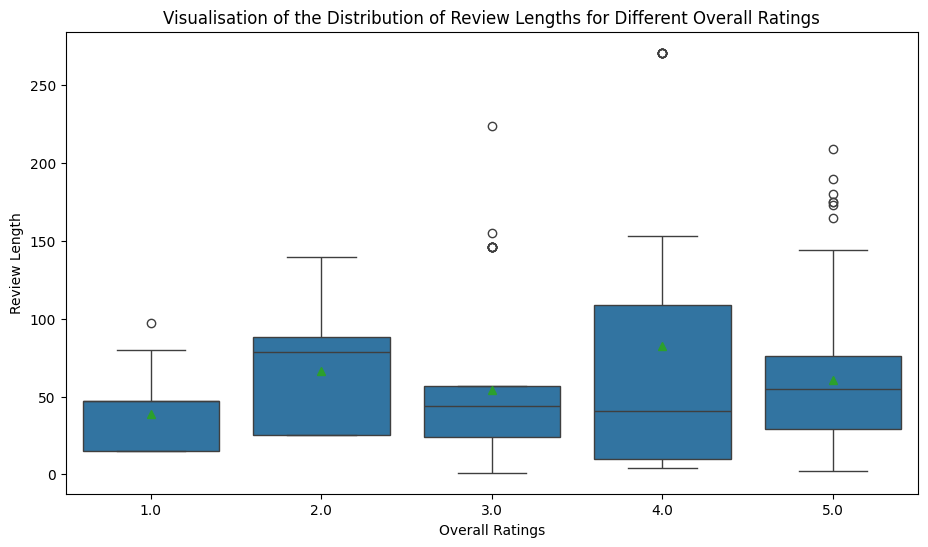

In [37]:
### Plot
plt.figure(figsize=(11, 6))
sns.boxplot(x="overall", y="reviewText_length", data=positive_vote_df, showmeans=True)

plt.title("Visualisation of the Distribution of Review Lengths for Different Overall Ratings")
plt.xlabel("Overall Ratings")
plt.ylabel("Review Length")

plt.show()

In [38]:
'''
Reviews with positive overall ratings (>=4.0) have higher mean Review Lengths as compared to those with negative overall ratings (<=2.0).
Perhaps, this may be due to positive-reviewers having more to praise about the respective products as compared to negative-reviewers who
did not leave long critisisms.
Interestingly, reviews with overall ratings or 2 have the highest median Review Length.
'''

'\nReviews with positive overall ratings (>=4.0) have higher mean Review Lengths as compared to those with negative overall ratings (<=2.0).\nPerhaps, this may be due to positive-reviewers having more to praise about the respective products as compared to negative-reviewers who\ndid not leave long critisisms.\nInterestingly, reviews with overall ratings or 2 have the highest median Review Length.\n'

#### size feedback and overall ratings
**Purpose**: Check if the distribution of fitting feedback differs by the overall rating

1. Create a list named `size_feedback_columns` containing the 5 size feedback categories: `'Too small', 'Somewhat small', 'Fits as expected', 'Somewhat large', and 'Too large'`.

2. Generate a new dataframe from `data_df` by keeping the rows where the **sum** of the size feedback columns is greater than 0 (set as `size_feedback_data`).

3. Group the `size_feedback_data` DataFrame by the `asin` column and calculate the mean of `overall` (rating) and the mean of each size feedback column (set as `product_level_data`).

4. We would like to check the percentage of fit and unfit by creating two new columns `fit_perc` and `unfit_perc` in the `product_level_data` DataFrame based on the formulas below:
  - `fit_perc` = `Fits as expected` / (`Too small`+`Somewhat small`+`Fits as expected`+`Somewhat large`+`Too large`)
  - `unfit_perc` = `Too small`+`Too large` / (`Too small`+`Somewhat small`+`Fits as expected`+`Somewhat large`+`Too large`)

6. Create two scatter plots side by side:
  - Create a scatter plot on the left with 'Overall' (`overall`) on the x-axis and 'Fit Percentage' (`fit perc`) on the y-axis. Use blue color and add labels and the legend.
  - Create a scatter plot on the right with 'Overall' (`overall`) on the x-axis and 'Unfit Percentage' (`unfit perc`) on the y-axis. Use red color and add labels and a legend.

In [39]:
### List of size feedback columns
size_feedback_columns = ["Too small", "Somewhat small", "Fits as expected", "Somewhat large", "Too large"]

### size_feedback_data
size_feedback_data = data_df[data_df[size_feedback_columns].sum(axis=1)> 0]

### product_level_data
product_level_data = size_feedback_data.groupby("asin").agg({"overall": "mean", **{size_type: "mean" for size_type in size_feedback_columns}})
# print(product_level_data)

### fit_perc and unfit_perc
product_level_data["fit_perc"] = product_level_data["Fits as expected"] / product_level_data[size_feedback_columns].sum(axis=1)
product_level_data["unfit_perc"] = (product_level_data["Too small"] + product_level_data["Too large"]) / product_level_data[size_feedback_columns].sum(axis=1)
product_level_data

,overall,Too small,Somewhat small,Fits as expected,Somewhat large,Too large,fit_perc,unfit_perc
asin,,,,,,,,
B000K2PJ4K,4.200000,64.0,61.0,296.0,6.0,3.0,0.688372,0.155814
B000KPIHQ4,4.142857,73.0,128.0,7641.0,233.0,134.0,0.930808,0.025216
B000V0IBDM,4.142857,73.0,128.0,7644.0,233.0,134.0,0.930833,0.025207
B000YFSR5G,3.708333,12.0,35.0,682.0,140.0,105.0,0.700205,0.120123
B0012DR1LU,5.000000,270.0,273.0,2929.0,184.0,93.0,0.781275,0.096826
B0014F8TIU,2.750000,154.0,336.0,950.0,18.0,12.0,0.646259,0.112925
B0017LD0BM,3.200000,2.0,1.0,24.0,1.0,0.0,0.857143,0.071429
B0017LGD34,3.200000,2.0,1.0,24.0,1.0,0.0,0.857143,0.071429
B001IKJOLW,4.423823,10.0,27.0,502.0,65.0,30.0,0.791798,0.063091


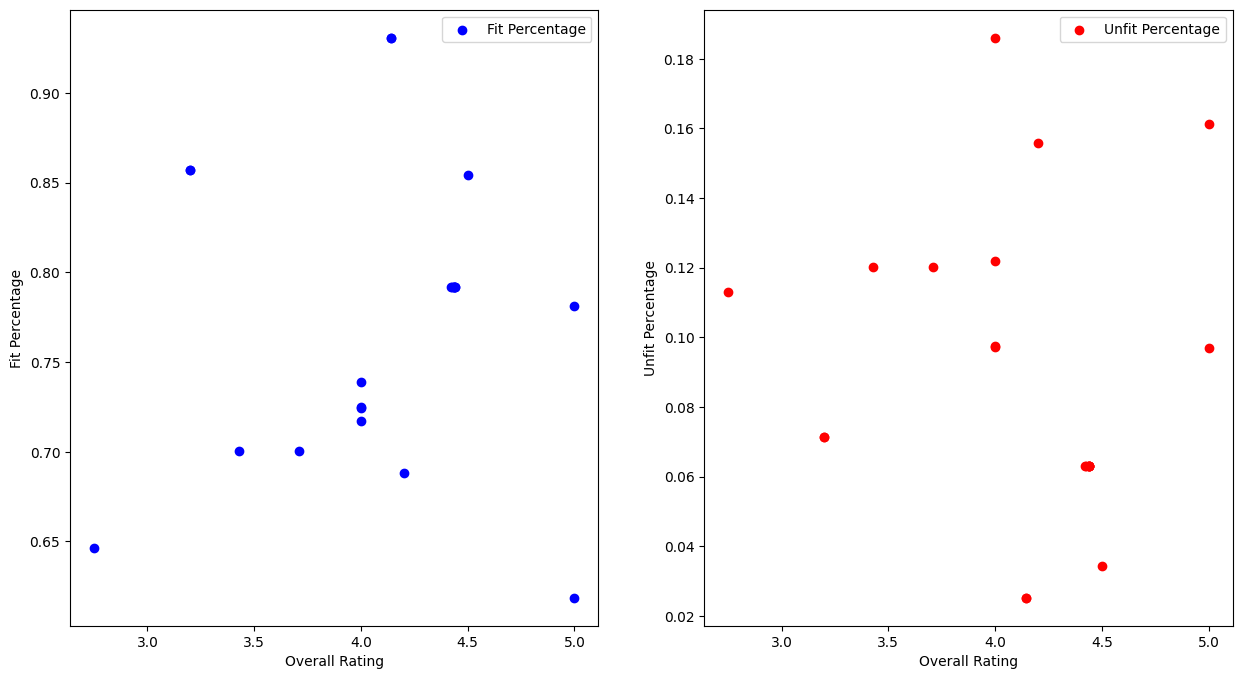

In [40]:
### Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

axes[0].scatter(product_level_data["overall"], product_level_data["fit_perc"], color="blue", label="Fit Percentage")
axes[0].set_xlabel("Overall Rating")
axes[0].set_ylabel("Fit Percentage")
axes[0].legend()

axes[1].scatter(product_level_data["overall"], product_level_data["unfit_perc"], color="red", label="Unfit Percentage")
axes[1].set_xlabel("Overall Rating")
axes[1].set_ylabel("Unfit Percentage")
axes[1].legend()

plt.show()

In [41]:
'''
The fit_perc scatterplot on the left shows that there is a slight positive correlation between fit percentage and overall rating. This is logical as items
that fit better will tend to garner better reviews and ratings. However, the relationship between fit and overall rating does not have a strong correlation.

It can be derived that most products fit well, since the lowest fit percentage is > 0.6, or 60%.
'''

'\nThe fit_perc scatterplot on the left shows that there is a slight positive correlation between fit percentage and overall rating. This is logical as items\nthat fit better will tend to garner better reviews and ratings. However, the relationship between fit and overall rating does not have a strong correlation.\n\nIt can be derived that most products fit well, since the lowest fit percentage is > 0.6, or 60%.\n'

#### Word Cloud
**Purpose**: A word cloud visually summarizes the most frequently occurring words in a product review, offering a quick and engaging way to highlight key themes, identify prevalent sentiments, and provide a concise overview of customer feedback.

1. Define a function `extract_adjectives` that takes a piece of text as input, tokenizes it, performs part-of-speech tagging using `pos_tag`, and extracts adjectives (tag: "JJ").
2. Define a function `generate_word_cloud_adjectives` that takes a text, extracts adjectives, and generates a Word Cloud for visualization. Set the params as `width=800, height=400, background_color='white'`.
3. Create two variables `low_star_reviews` and `high_star_reviews` by combining all the processed_reviews for low and high ratings in `data_df` respectively. Use thresholds overall==1 for low ratings and overall==5 for high ratings.
4. Apply the `generate_word_cloud_adjectives` function to generate Word Clouds for adjectives in `low_star_reviews` and `high_star_reviews`.
5. Observe the generated Word Clouds and analyze the adjectives used in low and high rating reviews.

In [46]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [47]:
### Define function to extract adjectives
def extract_adjectives(text):
    tokens = word_tokenize(text.lower())
    tagged = pos_tag(tokens)
    adjectives = [word for word, pos in tagged if pos == "JJ"]
    return adjectives

In [48]:
### Define function to generate Word Cloud for adjectives
def generate_word_cloud_adjectives(text, title):
    wordcloud = None
    adj = extract_adjectives(text)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(adj))
    # Plot the Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

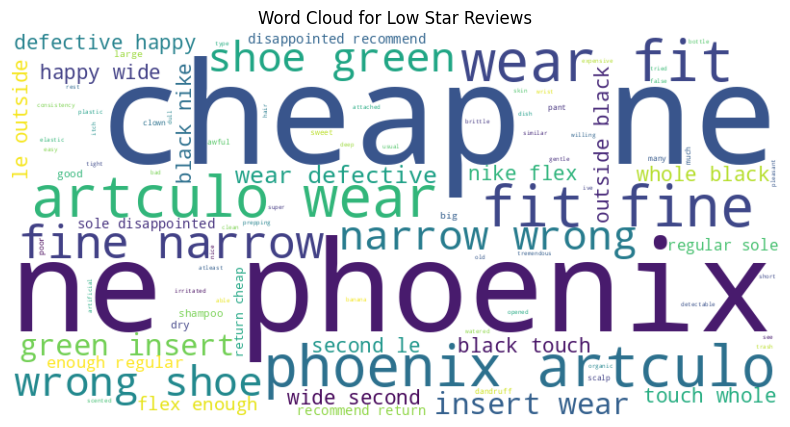

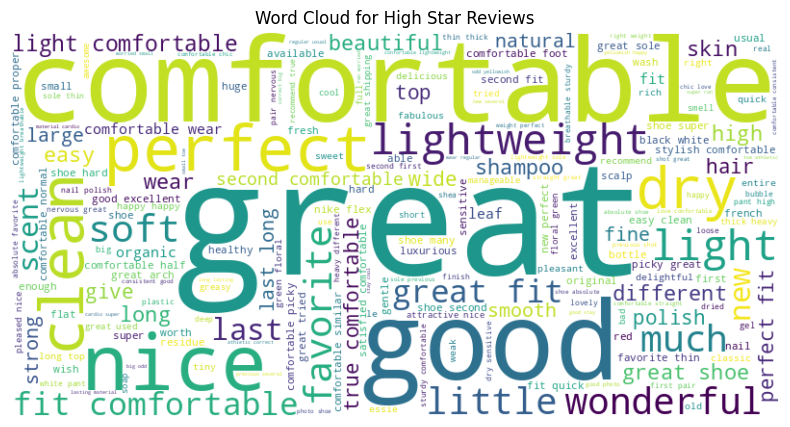

In [49]:
### Create low_star_reviews and high_star_reviews
low_star_reviews = " ".join(data_df[data_df["overall"] == 1]["processed_review"])
high_star_reviews = " ".join(data_df[data_df["overall"] == 5]["processed_review"])

### Generate two Word Clouds
generate_word_cloud_adjectives(low_star_reviews, "Word Cloud for Low Star Reviews")
generate_word_cloud_adjectives(high_star_reviews, "Word Cloud for High Star Reviews")

In [50]:
'''
The most prominent adjectives in the word cloud of low star reviews are "cheap" and "phoenix" (not too sure what phoenix means).
There are certain recurring words like "narrow" or "wrong" as well. This indicates that certain customers feel that the products they have rated are
of poor quality or fit, hence a negative sentiment can be derived from this.

On the contrary, prominent adjectives in the word cloud of high star reviews are "comfortable", "great", and "good". All of these are positive
adjectives.
'''

' \nThe most prominent adjectives in the word cloud of low star reviews are "cheap" and "phoenix" (not too sure what phoenix means). \nThere are certain recurring words like "narrow" or "wrong" as well. This indicates that certain customers feel that the products they have rated are \nof poor quality or fit, hence a negative sentiment can be derived from this.\n\nOn the contrary, prominent adjectives in the word cloud of high star reviews are "comfortable", "great", and "good". All of these are positive \nadjectives.\n'

# Part 2

Perform content based filtering for movie recommendation.

For the purposes of this section, the dataset used is the IMDB_top_1000.csv.

### Import Packages Needed

In [51]:
import pandas as pd
import numpy as np
### Plot
import matplotlib.pyplot as plt
import seaborn as sns
### Natural Language Processing
from sklearn.feature_extraction.text import TfidfVectorizer

### Download Data File Needed

In [54]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP' -O IMDB_top_1000.csv

--2024-02-07 07:19:45--  https://docs.google.com/uc?export=download&id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP
Resolving docs.google.com (docs.google.com)... 142.251.2.113, 142.251.2.139, 142.251.2.101, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP&export=download [following]
--2024-02-07 07:19:46--  https://drive.usercontent.google.com/download?id=1FgXwJNw1Pg2WtkWCYZCnsZGrHxpTvCVP&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98421 (96K) [application/octet-stream]
Saving to: ‘IMDB_top_1000.csv’

IMDB_top_1000.csv   100%[===================>]  96.11K  --.-KB/s    in 0.05

### Data Loading

For the purpose of this section, we will only consider two columns: `Title` and `Description`.

In [55]:
# Data Loading
raw_df = pd.read_csv("./IMDB_top_1000.csv")
movie_df = raw_df[['Title', 'Description']].copy()
print(movie_df.shape)
movie_df

(285, 2)


,Title,Description
0,The Shawshank Redemption,Two imprisoned men bond over a number of years...
1,The Godfather,The aging patriarch of an organized crime dyna...
2,The Dark Knight,When the menace known as the Joker wreaks havo...
3,The Godfather: Part II,The early life and career of Vito Corleone in ...
4,The Lord of the Rings: The Return of the King,Gandalf and Aragorn lead the World of Men agai...
...,...,...
280,Ghost in the Shell,A cyborg policewoman and her partner hunt a my...
281,The Nightmare Before Christmas,"Jack Skellington, king of Halloween Town, disc..."
282,Groundhog Day,A weatherman finds himself inexplicably living...
283,Aladdin,A kindhearted street urchin and a power-hungry...


### TF-IDF

TF-IDF is employed here to convert textual information (movie descriptions) into numerical vectors. This allows for content-based filtering by measuring the similarity between movies based on the importance and uniqueness of terms.

#### TfidfVectorizer

1. Create a TfidfVectorizer `tfidf` with English stop words.
2. Fit and transform the `Description` column of `movie_df` into `tfidf_scores`.
3. Check the shape of the resulting TF-IDF matrix (`tfidf_scores`)

In [56]:
### tfidf
tfidf = TfidfVectorizer(stop_words="english")
tfidf_scores = tfidf.fit_transform(movie_df["Description"])

In [57]:
### Check the shape of the resulting TF-IDF matrix (tfidf_scores)
### and explain the two dimension values

tfidf_scores.shape

### Row: 285, the number of unique movies' respective descriptions
### Column: 2363, the number of unique words across all the movie descriptions

(285, 2363)

### Cosine Similarity

#### cos_sim()

Define the `cos_sim()` function which takes two vectors: `vector_a` and `vector_b` (e.g.: `np.array([1, 2, 3])`) as inputs and returns the cosine similarity value of the two vectors.

In [58]:
### Define function to calculate cosine similarity
def cos_sim(vector_a, vector_b):
    similarity = 0
    dot_prod = np.dot(vector_a, vector_b)
    a = np.linalg.norm(vector_a)
    b = np.linalg.norm(vector_b)

    similarity = dot_prod / (a * b)
    return similarity

#### pairwise_cos_sim()

1. Define the `pairwise_cos_sim()` function to calculate the pairwise cosine similarity between a collection of vectors by making use of the `cos_sim()` defined in the previous task. The function takes `vectors` (e.g.: `np.array([[1,2,3],[1,2,3]])`) as input and returns the cosine similarity matrix (e.g.: `np.array([[1,1],[1,1]])`).
2. Apply the `pairwise_cos_sim()` function to `tfidf_scores.to_array()` to get the pairwise cosine similarity (`tfidf_cosine_sim`).

In [59]:
### Define function to calculate pairwise cosine similarity
def pairwise_cos_sim(vectors):
    similarity_matrix = None
    num_vect = vectors.shape[0]
    similarity_matrix = np.zeros((num_vect, num_vect))

    for i in range(num_vect):
        for j in range(num_vect):
            similarity_matrix[i, j] = cos_sim(vectors[i], vectors[j])

    return similarity_matrix

In [60]:
### tfidf_cos_sim
tfidf_cosine_sim = pairwise_cos_sim(tfidf_scores.toarray())
# tfidf_cosine_sim

#### top cosine similarity pair

1. Find the top cosine similarity score (`top_cos_sim`) between two different movie descriptions by flattening the `tfidf_cos_sim` into a 1D array, sorting the values by `sorted()`, and indexing to retrieve the cosine similarity score.
2. Explain the reason for the index chosen in step 1.
3. Use `np.argwhere` to find the indices where the maximum value (`top_cos_sim`) occurs in `tfidf_cos_sim`.
4. Print the title and the movie description of the movie pair identified

In [61]:
### top_cos_sim
flattened = tfidf_cosine_sim.flatten()
flattened = sorted(flattened, reverse=True)
# print(flattened)
top_cos_sim = flattened[285]
print(top_cos_sim)

'''
The cosine similarity matrix always has a maximum value of 1.0, indicating self-similarity -- logically this is because a movie is being compared
to itself. After printing flattened, and doing some trial and error, I have landed on index 285, being the first score that is not 1.
Opting for the second-highest value (which is not 1) allows us to identify the highest similarity between two distinct movie descriptions.
'''

0.47516870053040383


'\nThe cosine similarity matrix always has a maximum value of 1.0, indicating self-similarity -- logically this is because a movie is being compared\nto itself. After printing flattened, and doing some trial and error, I have landed on index 285, being the first score that is not 1.\nOpting for the second-highest value (which is not 1) allows us to identify the highest similarity between two distinct movie descriptions.\n'

In [62]:
### Find the indices of top_cos_sim
max_indices = np.argwhere(tfidf_cosine_sim == top_cos_sim)
# print(max_indices)

index_1, index_2 = max_indices[0]
title_1 = movie_df.iloc[index_1]["Title"]
desc_1 = movie_df.iloc[index_1]["Description"]

title_2 = movie_df.iloc[index_2]["Title"]
desc_2 = movie_df.iloc[index_2]["Description"]

In [63]:
### Print the title and the movie description of the movie pair identified
print(f"Movie 1 Title: {title_1}")
print(f"Movie 1 Desc: {desc_1}")
print(f"Movie 2 Title: {title_2}")
print(f"Movie 2 Desc: {desc_2}")

'''
Both movies have characters playing as a mole, and an undercover cop. The movie comprises of each of the characters trying to identify who
the other party is. Due to the similar character roles and a relatively similar plotline (excluding the setting of the story), it has a relatively
high consine similarity score
'''

Movie 1 Title: The Departed
Movie 1 Desc: An undercover cop and a mole in the police attempt to identify each other while infiltrating an Irish gang in South Boston.
Movie 2 Title: Infernal Affairs
Movie 2 Desc: A story between a mole in the police department and an undercover cop. Their objectives are the same: to find out who is the mole, and who is the cop.


'\nBoth movies have characters playing as a mole, and an undercover cop. The movie comprises of each of the characters trying to identify who\nthe other party is. Due to the similar character roles and a relatively similar plotline (excluding the setting of the story), it has a relatively\nhigh consine similarity score\n'

### Movie Recommendation

#### recommend_movies() (0.6 marks)

Define the `recommend_movies()` function with appropriate parameters. The function should take `data` (movie information Dataframe in the form of `movie_df`), `movie_name` (the title of the movie which should be within the input movie information Dataframe), `similarity_matrix` (matrix with pairwise cosine similarity scores like `tfidf_cosine_sim`) and an optional parameter `top_k` (the number of top recommendations, set the default value to be 5) as inputs and returns a Dataframe with the top k recommended movies:
1. Find and print the index of the input movie within the input DataFrame based on `Title` column.
2. Retrieve the cosine similarity scores for the input movie based on the index.
3. Sort the movie indices based on the similarity scores in descending order by using `np.argsort()`.
4. Extract the movie indices for the top k recommendation.
5. Use DataFrame indexing to retrieve a subset of the `data` DataFrame as `rec_df` which contains the details of the recommended movies.
6. Add one additional column `Similarity Score` to `rec_df` which contains the corresponding cosine similarity score between each recommended movie and the input movie.

In [2]:
### Define function to recommend movies
def recommend_movies(data, movie_name, similarity_matrix, top_k=5):
    output_df = pd.DataFrame()
    index = movie_df.loc[movie_df["Title"] == movie_name].index[0]
    similarity_scores = similarity_matrix[index]
    descending_indices = np.argsort(similarity_scores)[::-1]
    top_k_indices = [i for i in descending_indices if i != index][:top_k]
    output_df = data.iloc[top_k_indices].copy()
    output_df["Similarity Score"] = similarity_scores[top_k_indices]

    return output_df

#### Batman Begins
Apply the `recommend_movies()` function to recommend two movies similar to the movie `"Batman Begins"`. Set `data` to be `movie_df` and `similarity_matrix` to `tfidf_cos_sim`.

In [3]:
recs = recommend_movies(movie_df, "Batman Begins", tfidf_cosine_sim, top_k=5)
recs

NameError: name 'movie_df' is not defined

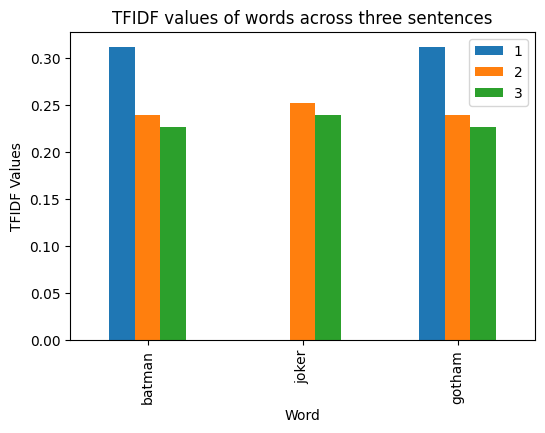

In [66]:
### TFIDF values visualization
keywords = ['batman', 'joker', 'gotham']
feature_names = tfidf.get_feature_names_out()

# # TFIDF values of keywords in "Batman Begins" description
tfidf_scores_array_1 = tfidf_scores.toarray()[117]
word_tfidf_dict_1 = dict(zip(feature_names, tfidf_scores_array_1))
tfidf_1 = {word: word_tfidf_dict_1[word] for word in keywords}

# # TFIDF values of keywords in "The Dark Knight Rises" description
tfidf_scores_array_2 = tfidf_scores.toarray()[56]
word_tfidf_dict_2 = dict(zip(feature_names, tfidf_scores_array_2))
tfidf_2 = {word: word_tfidf_dict_2[word] for word in keywords}

# TFIDF values of keywords in "The Dark Knight" description
tfidf_scores_array_3 = tfidf_scores.toarray()[2]
word_tfidf_dict_3 = dict(zip(feature_names, tfidf_scores_array_3))
tfidf_3 = {word: word_tfidf_dict_3[word] for word in keywords}

# Create DataFrames
df1 = pd.DataFrame(list(tfidf_1.items()), columns=['Word', '1'])
df2 = pd.DataFrame(list(tfidf_2.items()), columns=['Word', '2'])
df3 = pd.DataFrame(list(tfidf_3.items()), columns=['Word', '3'])

# Merge DataFrames on 'Word'
merged_df = pd.merge(df1, df2, on='Word')
merged_df = pd.merge(merged_df, df3, on='Word')

# Plotting
ax = merged_df.plot(kind='bar', x='Word', figsize=(6,4))

# Adding labels and title
ax.set_xlabel('Word')
ax.set_ylabel('TFIDF Values')
plt.title('TFIDF values of words across three sentences')

# Show the plot
plt.show()